indicator #1
goal: identify bollinger band squeeze in stock data

In [6]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import datetime 

# stock market data

In [7]:
df = yf.download("SPY", start="2024-06-10", end="2024-09-10").drop(['Adj Close'], axis=1)
print(df.head())

[*********************100%***********************]  1 of 1 completed

                  Open        High         Low       Close    Volume
Date                                                                
2024-06-10  533.179993  535.989990  532.570007  535.659973  35729300
2024-06-11  534.070007  537.010010  532.049988  536.950012  36383400
2024-06-12  541.630005  544.119995  540.299988  541.359985  63251300
2024-06-13  543.150024  543.330017  539.590027  542.450012  44760900
2024-06-14  540.880005  542.809998  539.849976  542.780029  40089900


# keltner channel

In [8]:
def get_kc(high, low, close, kc_lookback=20, multiplier=1.5, atr_lookback=20):
    '''
    kc_lookback = period
    multiplier = 2
    ATR = 10 or 20 periods
    '''
    
    # ATR calculation
    tr1 = pd.DataFrame(high - low)
    tr2 = pd.DataFrame(abs(high - close.shift()))
    tr3 = pd.DataFrame(abs(low - close.shift()))
    frames = [tr1, tr2, tr3]
    tr = pd.concat(frames, axis = 1, join = 'inner').max(axis = 1)
    atr = tr.ewm(alpha = 1/atr_lookback).mean()
    
    # exponential moving average (EMA)
    kc_middle = close.ewm(kc_lookback).mean()
    kc_upper = kc_middle + multiplier * atr
    kc_lower = kc_middle - multiplier * atr
    
    return kc_middle, kc_upper, kc_lower


kc_df = df.copy()
kc_df['kc_middle'], kc_df['kc_upper'], kc_df['kc_lower'] = get_kc(kc_df['High'], kc_df['Low'], kc_df['Close'])
kc_df.tail()

,Open,High,Low,Close,Volume,kc_middle,kc_upper,kc_lower
Date,,,,,,,,
2024-09-03,560.469971,560.809998,549.510010,552.080017,60600100,550.255767,561.765869,538.745665
2024-09-04,550.200012,554.429993,549.460022,550.950012,47224900,550.290696,561.588249,538.993143
2024-09-05,550.890015,553.799988,547.099976,549.609985,44264300,550.256540,561.488861,539.024219
2024-09-06,549.940002,551.599976,539.440002,540.359985,68493800,549.761224,561.359127,538.163320
2024-09-09,544.650024,547.710022,542.679993,546.409973,40445800,549.593902,561.161985,538.025819


graph keltner channels

https://github.com/matplotlib/mplfinance/blob/master/examples/using_lines.ipynb

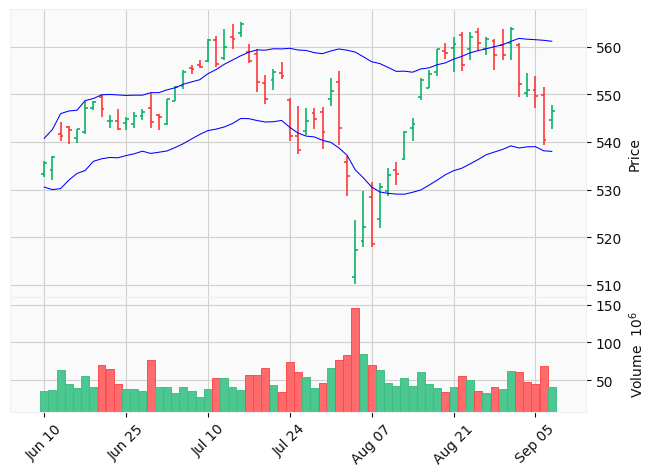

In [9]:
apd = [
    mpf.make_addplot(kc_df[['kc_lower', 'kc_upper']], color='b', width=.75),
    ]   

mpf.plot(kc_df, volume=True, addplot=apd, style='yahoo') 

# bollinger band

In [10]:
def get_bb(close, window=20, multiplier=1.5):
    '''
    Type(close) = Pandas
    window = 20
    multiplier = 1.5
    '''
    
    # Calculate the 20-period Simple Moving Average (SMA)
    sma = close.rolling(window=20).mean()
    
    # Calculate the 20-period Standard Deviation (SD)
    std = close.rolling(window=20).std()
    
    # Calculate the Upper Bollinger Band (UB) and Lower Bollinger Band (LB)
    upper = sma + 2 * std
    lower = sma - 2 * std
    
    return upper, lower

bb_df = df.copy()
bb_df['bb_upper'], bb_df['bb_lower'] = get_bb(bb_df['Close'])
bb_df.tail()

,Open,High,Low,Close,Volume,bb_upper,bb_lower
Date,,,,,,,
2024-09-03,560.469971,560.809998,549.510010,552.080017,60600100,577.668392,520.624601
2024-09-04,550.200012,554.429993,549.460022,550.950012,47224900,576.121154,525.051838
2024-09-05,550.890015,553.799988,547.099976,549.609985,44264300,572.811188,531.456805
2024-09-06,549.940002,551.599976,539.440002,540.359985,68493800,571.555379,533.683610
2024-09-09,544.650024,547.710022,542.679993,546.409973,40445800,570.133000,536.447987


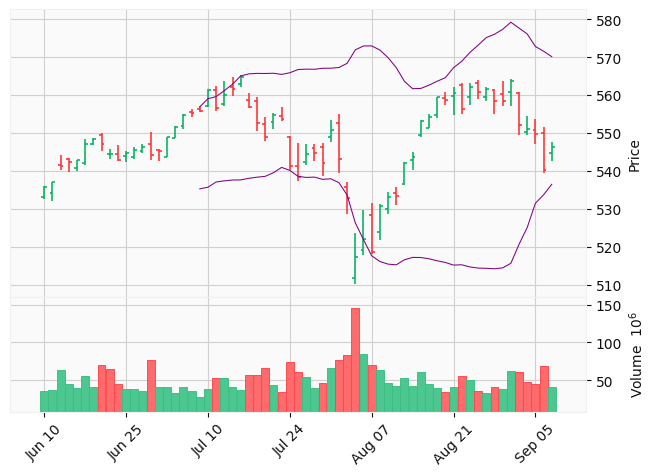

In [11]:
apd = [
    mpf.make_addplot(bb_df[['bb_lower', 'bb_upper']], color='purple', width=.75),
    ]   

mpf.plot(bb_df, volume=True, addplot=apd, style='yahoo') 

# identify bollinger band squeeze

bollinger bands drop within keltner channel bounds

In [12]:
def get_bb_squeeze(df):
    ''' 
    df must contain cols: ['bb_upper', 'bb_lower', 'kc_upper', 'kc_lower']
    '''
    squeeze = (df['bb_upper'] < df['kc_upper']) & (df['bb_lower'] > df['kc_lower'])
    return squeeze.astype(int)


In [13]:
def concat_kb_bb(df):
    '''
    df must contain cols: ['High', 'Low', 'Close']
    '''
    df = df.copy()
    df['bb_upper'], df['bb_lower'] = get_bb(df['Close'])
    df['kc_middle'], df['kc_upper'], df['kc_lower'] = get_kc(df['High'], df['Low'], df['Close'])
    df['bb_squeeze'] = get_bb_squeeze(df)
    return df

                  Open        High         Low       Close    Volume  \
Date                                                                   
2024-09-03  560.469971  560.809998  549.510010  552.080017  60600100   
2024-09-04  550.200012  554.429993  549.460022  550.950012  47224900   
2024-09-05  550.890015  553.799988  547.099976  549.609985  44264300   
2024-09-06  549.940002  551.599976  539.440002  540.359985  68493800   
2024-09-09  544.650024  547.710022  542.679993  546.409973  40445800   

              bb_upper    bb_lower   kc_middle    kc_upper    kc_lower  \
Date                                                                     
2024-09-03  577.668392  520.624601  550.255767  561.765869  538.745665   
2024-09-04  576.121154  525.051838  550.290696  561.588249  538.993143   
2024-09-05  572.811188  531.456805  550.256540  561.488861  539.024219   
2024-09-06  571.555379  533.683610  549.761224  561.359127  538.163320   
2024-09-09  570.133000  536.447987  549.593902  561

c:\Users\gvnin\Documents\projects\trading_bot\venv\Lib\site-packages\mplfinance\plotting.py:801: UserWarning: 
 addplot MISMATCH between data and labels:
 have 2 columns to plot 
 BUT  1 labels for them.

  warnings.warn('\n =======================================\n'+


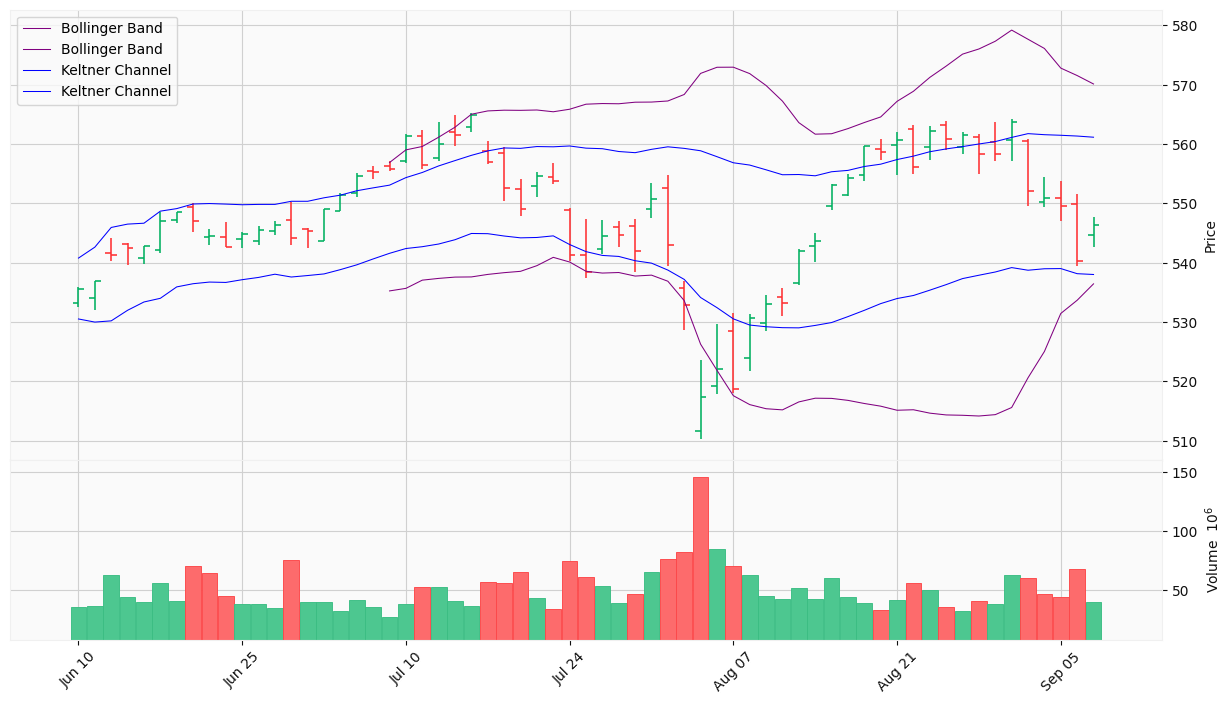

In [14]:
test_df = df.copy()

test_df = concat_kb_bb(test_df)
print(test_df.tail())

apd = [
    mpf.make_addplot(test_df[['bb_lower', 'bb_upper']], color='purple', width=.75, label='Bollinger Band'),
    mpf.make_addplot(test_df[['kc_lower', 'kc_upper']], color='b', width=.75, label='Keltner Channel'),
    ]   

fig, ax = mpf.plot(test_df, volume=True, addplot=apd, style='yahoo', returnfig=True, figsize=(16,9)) 

# final

In [15]:
def search_stock(ticker, START, END):
    
    '''
    dates must be within <30d of present for yahoofinance API to have 5min interval data
    ''' 
    
    df = yf.download(ticker, start=START, end=END, interval="5m").drop(['Adj Close'], axis=1)
    df = concat_kb_bb(df)

    apd = [
        mpf.make_addplot(df[['bb_lower', 'bb_upper']], color='purple', width=.75, label='Bollinger Band'),
        mpf.make_addplot(df[['kc_lower', 'kc_upper']], color='b', width=.75, label='Keltner Channel'),
        mpf.make_addplot(df['bb_squeeze'], color='c', width=.75, label='BB Squeeze'),
        ]   

    fig, ax = mpf.plot(df, volume=True, addplot=apd, style='yahoo', returnfig=True, figsize=(16,9)) 

[*********************100%***********************]  1 of 1 completed
c:\Users\gvnin\Documents\projects\trading_bot\venv\Lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+
c:\Users\gvnin\Documents\projects\trading_bot\venv\Lib\site-packages\mplfinance\plotting.py:801: UserWarning: 
 addplot MISMATCH between data and labels:
 have 2 columns to plot 
 BUT  1 labels for them.

  warnings.warn('\n =======================================\n'+


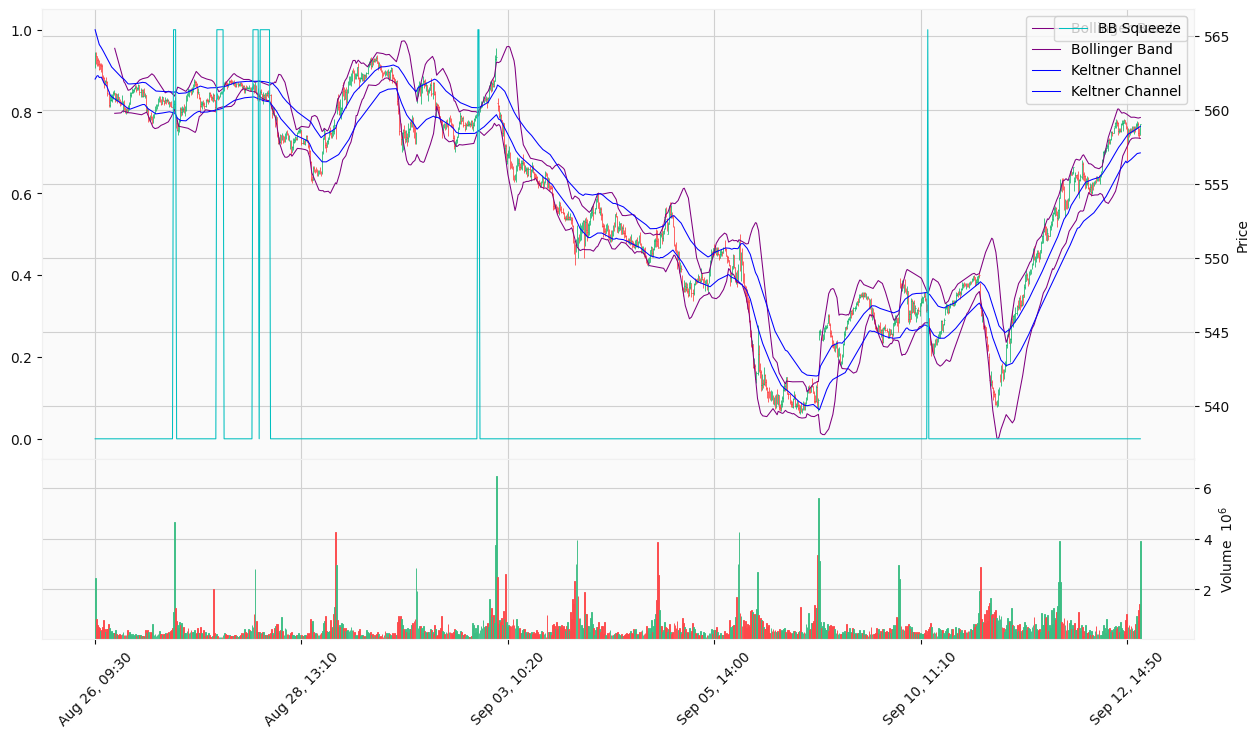

In [16]:
ticker = 'SPY' 
num_days = 20 # length of time window into the past to search

START = (datetime.datetime.now() - datetime.timedelta(days=num_days)).strftime("%Y-%m-%d") 
END = datetime.datetime.now().strftime("%Y-%m-%d")

search_stock(ticker=ticker, START=START, END=END)

[*********************100%***********************]  1 of 1 completed
c:\Users\gvnin\Documents\projects\trading_bot\venv\Lib\site-packages\mplfinance\plotting.py:801: UserWarning: 
 addplot MISMATCH between data and labels:
 have 2 columns to plot 
 BUT  1 labels for them.

  warnings.warn('\n =======================================\n'+


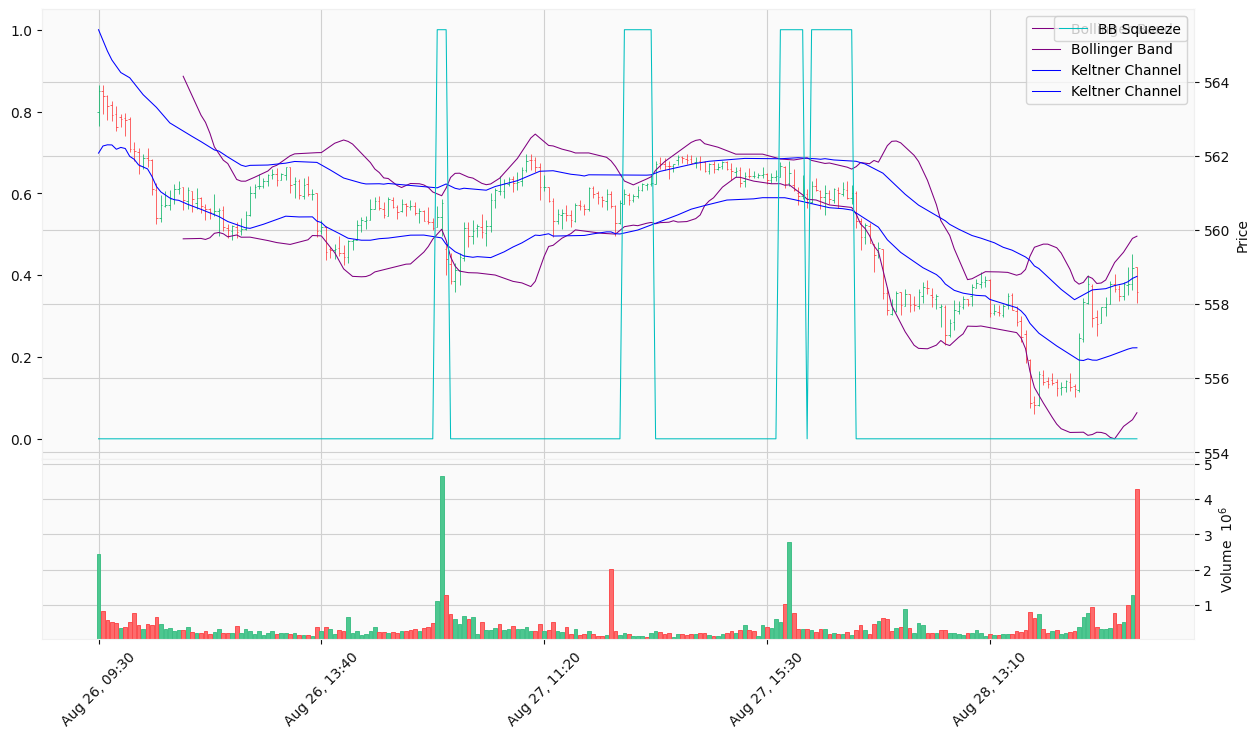

In [17]:
START = "2024-08-26"
END = "2024-08-29"
ticker = 'SPY' 

search_stock('SPY', START=START, END=END)